Key things to do:
- make plt.imshow() plots over a grid of baselines from -50 to +50 m in x and y
- with a single point source, look at visibility as a function baseline vector, both real/imag and abs/angle
- try varying point source position, try varying the frequency
- try adding multiple sources with same/different flux
- bonus: try doing a 2D FFT of your grid
- pick frequency between 100 and 200 MHz
- start with "unit beam" = 1
- can also try Gaussian beam with some scale width from the zenith

W2
- vectorizing calculations in numpy (put things in numpy arrays rather than just lists)
- use docstrings
- use shift tab
- learn np.meshgrid, for real this time


W3
- understanding the relationship/difference between antenna space vs. baseline space
- setting up dictionary for antennae, and get to a set of visibility values from there
- What happens when we average non-redundancies?
    - so take a set of redundancies and then preturb the positions of several antenna. What happens then?


W4
- don't forget to actually find the visibility values using the dictionary
- simulate perturbations
- whether or not the average visibility within one redundant group depends on level of perturbation (order or magnitude)
- try with more point sources
- how does absolute value of the average compare to average of the absolute value?
- start with one set of redundant baselines; then see if this has varied effects for other baselines
- should expect a descrepancy between the two values
- if you have time, try airy beam

In [1]:
import numpy as np
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


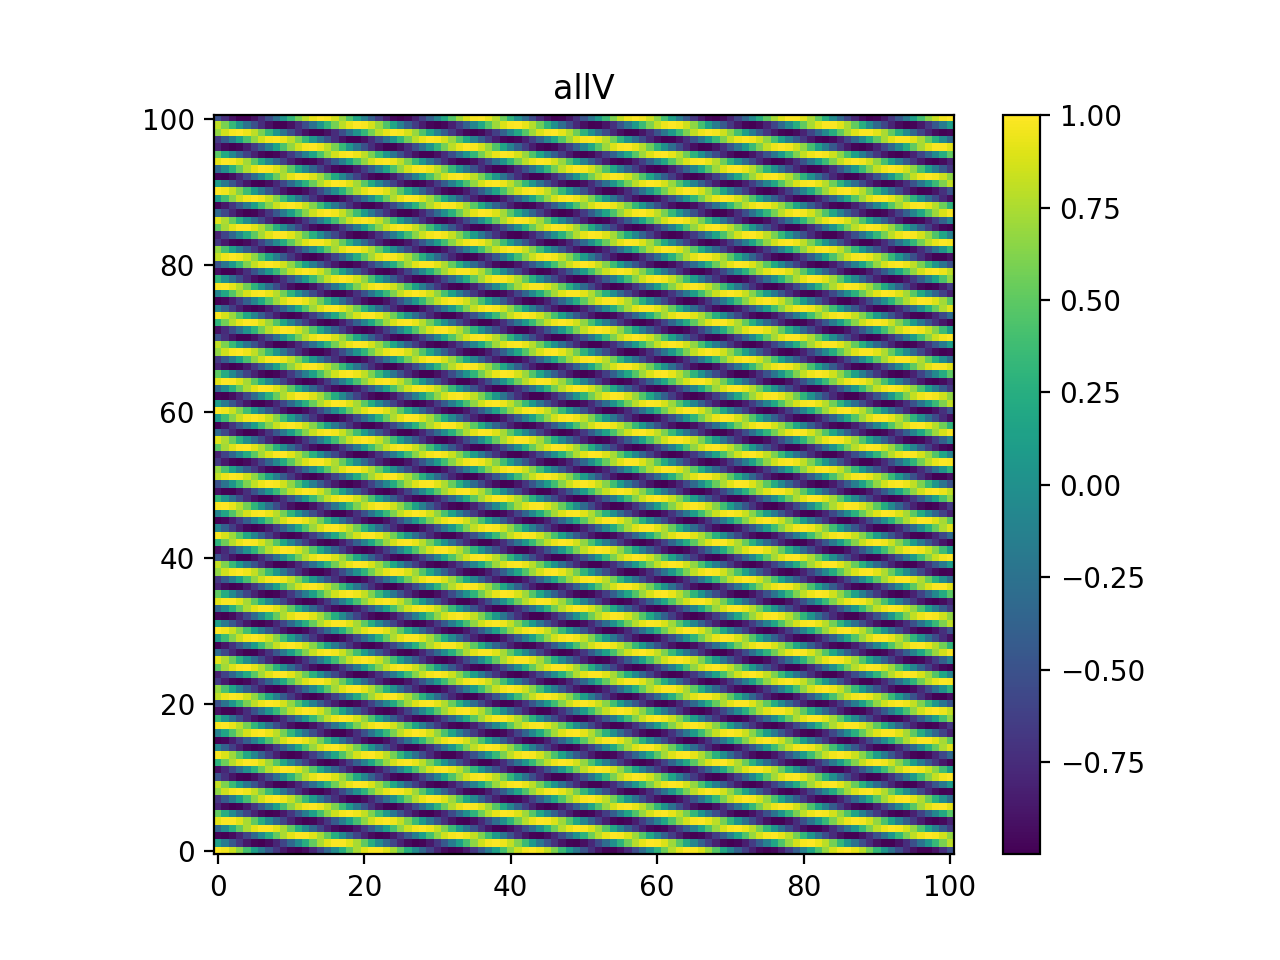

In [8]:
import numpy as np
def Vsimple(freq, b, r):
    ''' frequency in Hz
     normalizes r vector
     '''
    c = 3*10**8
    flux = 1
    r = r/np.linalg.norm(r)
    return flux*np.exp(-2*np.pi*1j*(freq/c)*np.dot(b,r))

# np.linalg.norm(r) gives us the magnitude of the vector, and to normalize we divide it through like this:
# where "r /= a" is really "r = r/a"
### Interesting issue: using r /= a causes issues for many values of components for r, when r is an array

rtest = np.array([0.2, 1, 1])

# Vsimple(1e8, b, r)
# freqs = np.linspace(1e8, 2e8, 100)
# Vsimple(freqs, b, r)

baselines = np.array(np.meshgrid(np.arange(-50,51), np.arange(-50,51), [0]))
baselines = baselines.reshape(3,-1).T

allV = np.array([Vsimple(1e8, b, rtest) for b in baselines]).reshape(101,101)

%matplotlib notebook
plt.figure()
plt.title("allV")
plt.imshow(allV.real,origin='lower')
plt.colorbar()

plt.show()



<IPython.core.display.Javascript object>


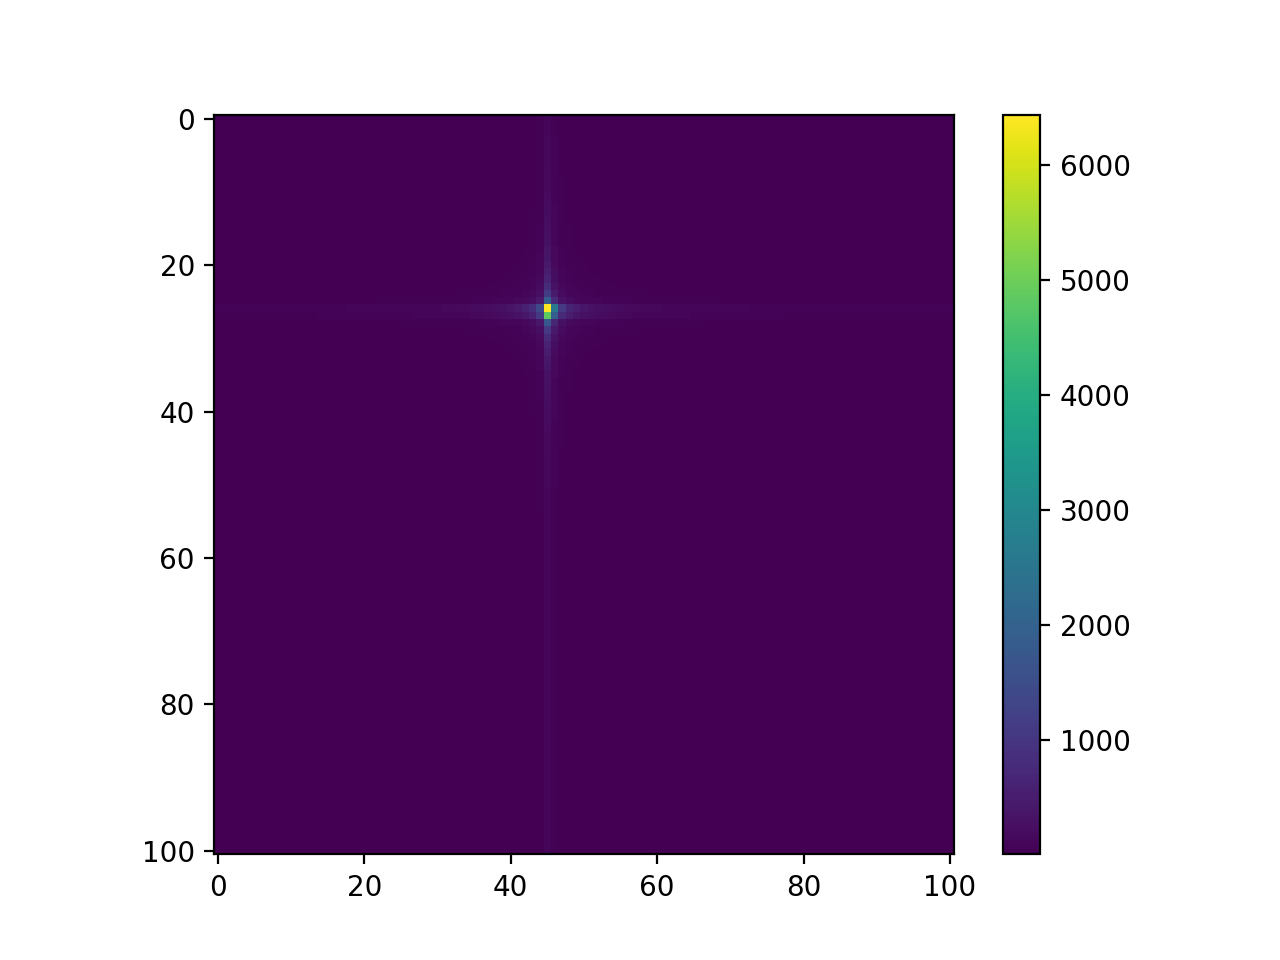

In [3]:
plt.figure()
# should just memorize this line for FFT
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(allV))))
plt.colorbar()
plt.show()


<IPython.core.display.Javascript object>


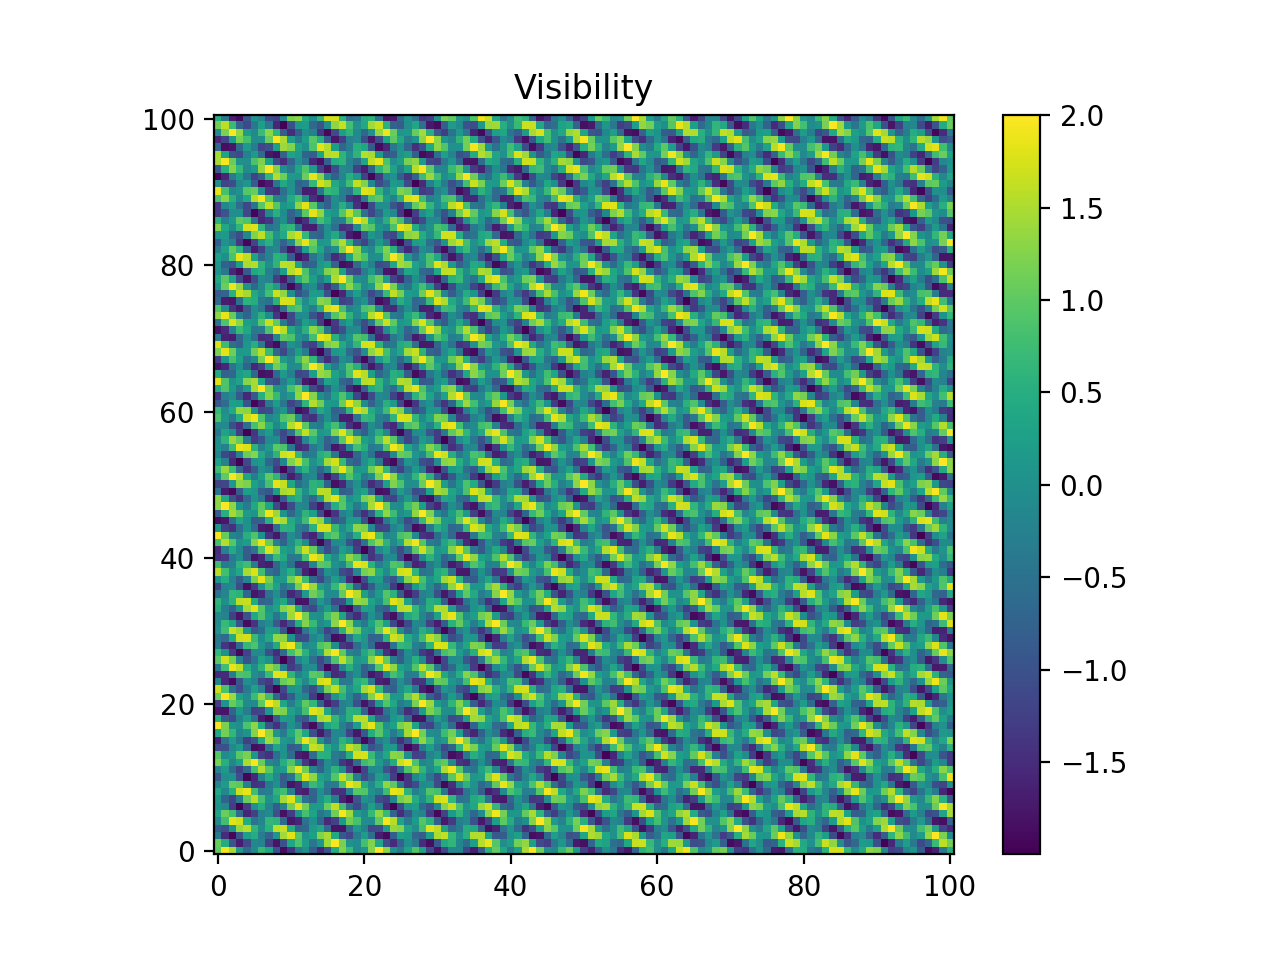

<IPython.core.display.Javascript object>


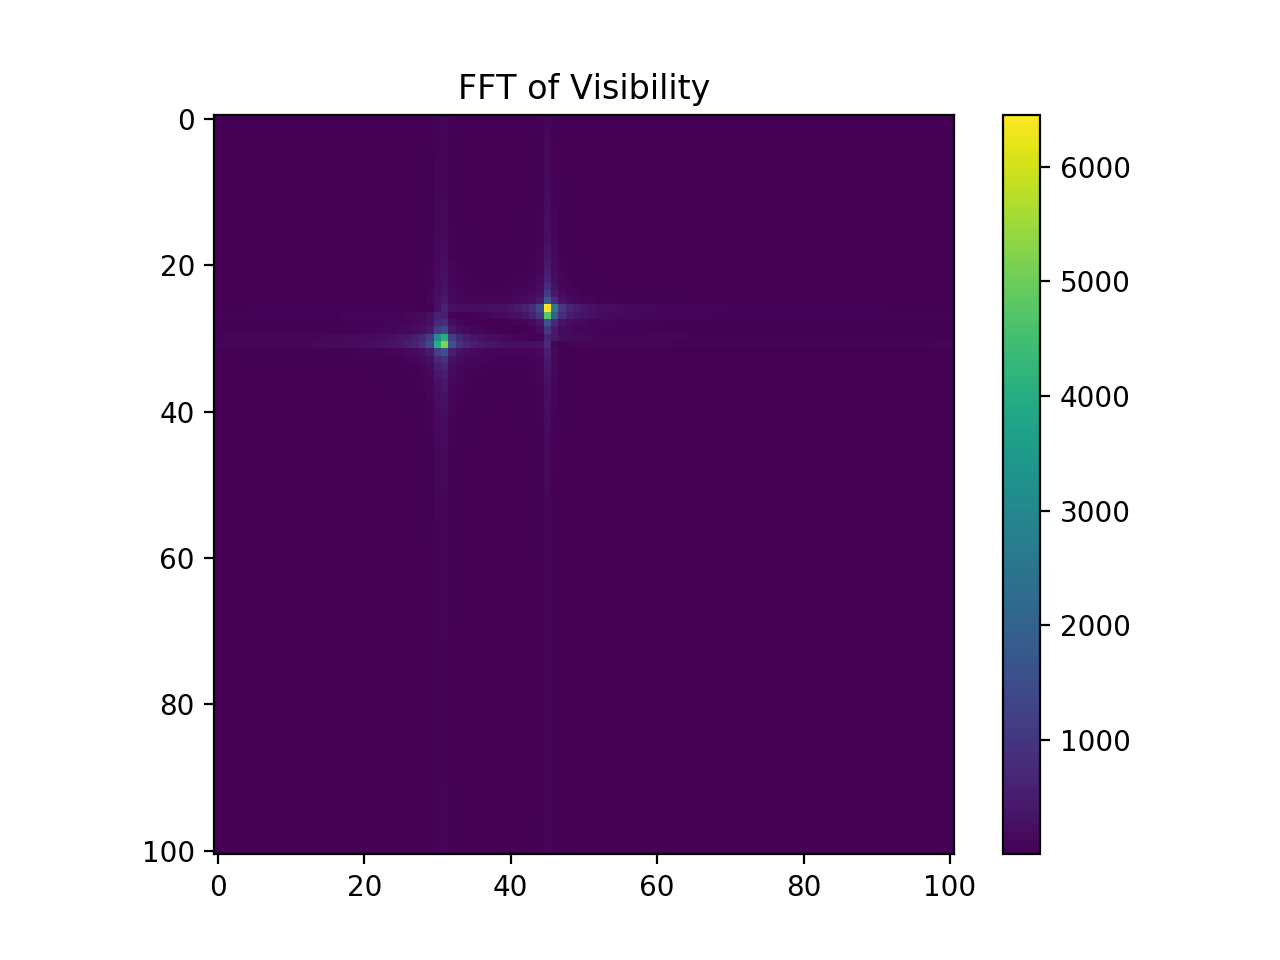

In [4]:
# Visibility as the result of 2 point sources

rtest2 = np.array([1, 1, 1])
allV2 = allV + np.array([Vsimple(1e8, b, rtest2) for b in baselines]).reshape(101,101)

plt.figure()
plt.title("Visibility")
plt.imshow(allV2.real,origin='lower')
plt.colorbar()


plt.figure()
plt.title("FFT of Visibility")
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(allV2))))
plt.colorbar()
plt.show()



In [9]:
import hera_cal
from hera_cal.redcal import get_pos_reds

#without perturbation
antpos = {}
n = 0
for i in range(10):
    for j in range(10):
        n += 1
        antpos[n] = np.array([i,j])
reds = get_pos_reds(antpos, 0.01)
print(antpos[2])
for red in reds: print(red,'\n')

[0 1]
[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (31, 32), (32, 33), (33, 34), (34, 35), (35, 36), (36, 37), (37, 38), (38, 39), (39, 40), (41, 42), (42, 43), (43, 44), (44, 45), (45, 46), (46, 47), (47, 48), (48, 49), (49, 50), (51, 52), (52, 53), (53, 54), (54, 55), (55, 56), (56, 57), (57, 58), (58, 59), (59, 60), (61, 62), (62, 63), (63, 64), (64, 65), (65, 66), (66, 67), (67, 68), (68, 69), (69, 70), (71, 72), (72, 73), (73, 74), (74, 75), (75, 76), (76, 77), (77, 78), (78, 79), (79, 80), (81, 82), (82, 83), (83, 84), (84, 85), (85, 86), (86, 87), (87, 88), (88, 89), (89, 90), (91, 92), (92, 93), (93, 94), (94, 95), (95, 96), (96, 97), (97, 98), (98, 99), (99, 100)] 

[(1, 11), (2, 12), (3, 13), (4, 14), (5, 15), (6, 16), (7, 17), (8, 18), (9, 19), (10, 20), (11, 21), (12, 

(180, 3)
(15, 12)


<IPython.core.display.Javascript object>


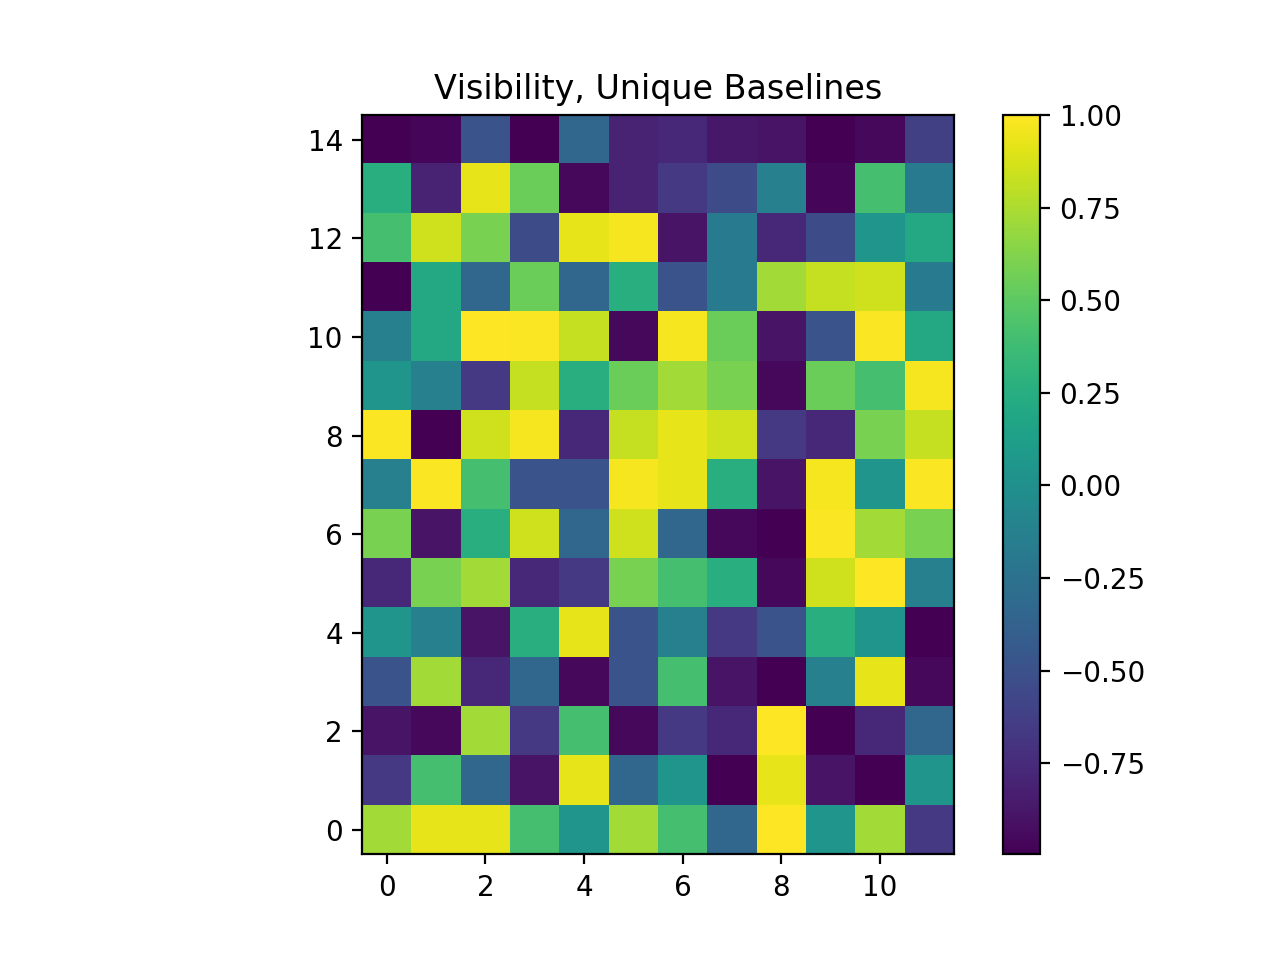

<IPython.core.display.Javascript object>


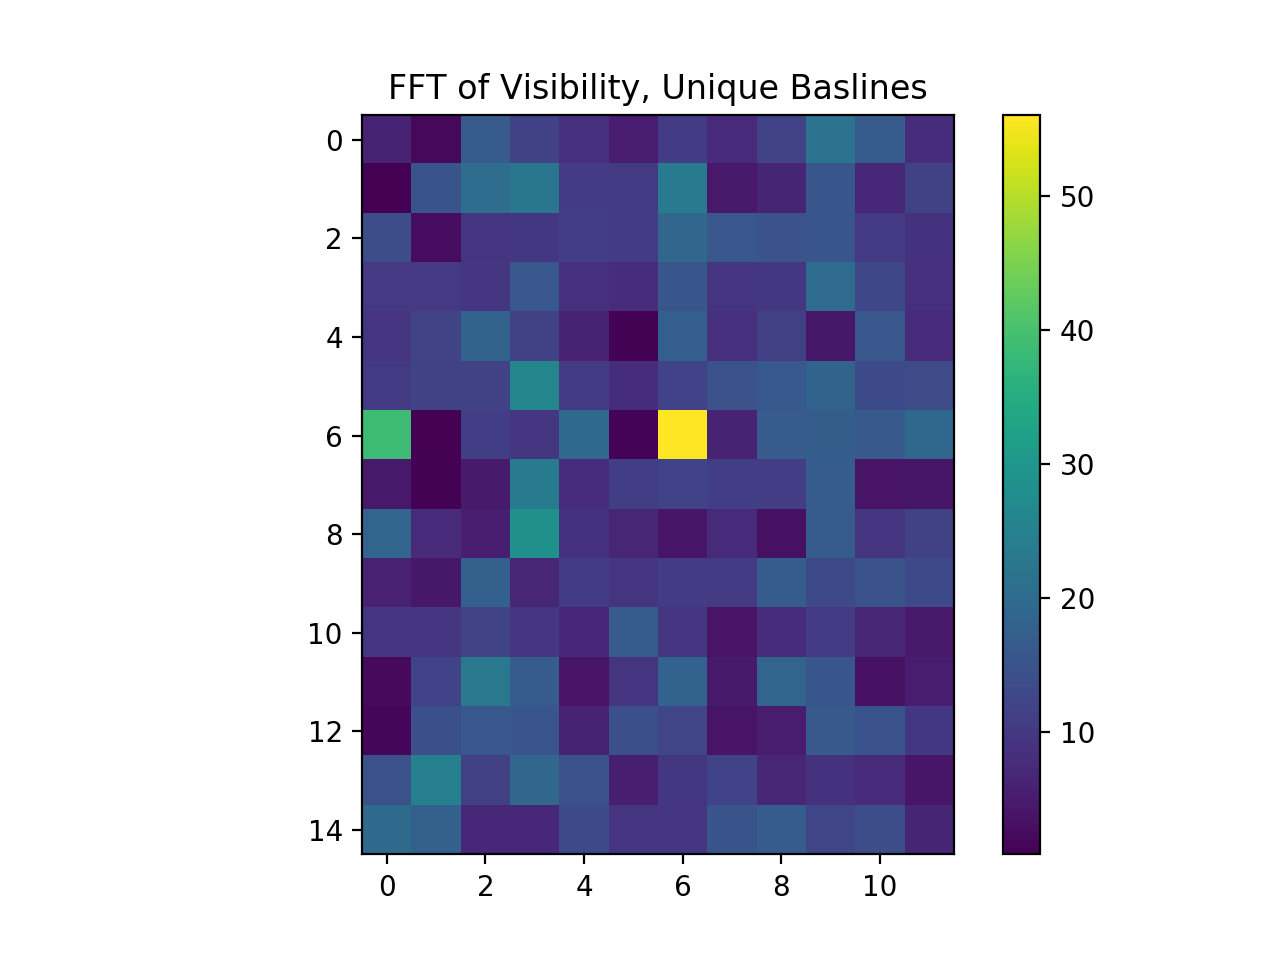

In [18]:
# The first element of each item in "reds" is a couple, containing the labels of two antennae. Using these labels, we
# can grab their respective positions. Subtracting these positions yields a single, unique baseline. We then add the 
# z component (which is zero) to each baseline, and then add THAT to a full list of unique baselines. Finally, we convert
# the list into an array.
Ubaselines = []
for redItem in reds:
    Ubaseline = antpos[redItem[0][1]] - antpos[redItem[0][0]]
    Ubaselines.append(np.append(Ubaseline, [0]))
Ubaselines = np.array(Ubaselines)

r = [1,2,5]
Vunique = np.array([Vsimple(1e8, b, r) for b in Ubaselines]).reshape(15,12)
print(Ubaselines.shape)
print(Vunique.shape)

plt.figure()
plt.title("Visibility, Unique Baselines")
plt.imshow(Vunique.real,origin='lower')
plt.colorbar()

plt.figure()
plt.title("FFT of Visibility, Unique Baslines")
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(Vunique))))
plt.colorbar()
plt.show()

In [30]:
# Given a set of antennae positions and source position(s), produce a set of visibilities from unique baselines.
# Note: Cannot (easily) reshape the set of Visibilities for the general case; user will need to determine grid shape 
# based on final size.
def get_Vis_from_antpos(antpos, r):
    '''Given a set of antennae positions and source position(s), produce a set of visibilities from unique baselines.
     Note: Cannot (easily) reshape the set of Visibilities for the general case; user will need to determine grid shape 
     based on final size.
     '''
    Ubaselines = []
    for redItem in reds:
        Ubaseline = antpos[redItem[0][1]] - antpos[redItem[0][0]]
        Ubaselines.append(np.append(Ubaseline, [0]))
    Ubaselines = np.array(Ubaselines)
    return np.array([Vsimple(1e8, b, r) for b in Ubaselines])

<IPython.core.display.Javascript object>


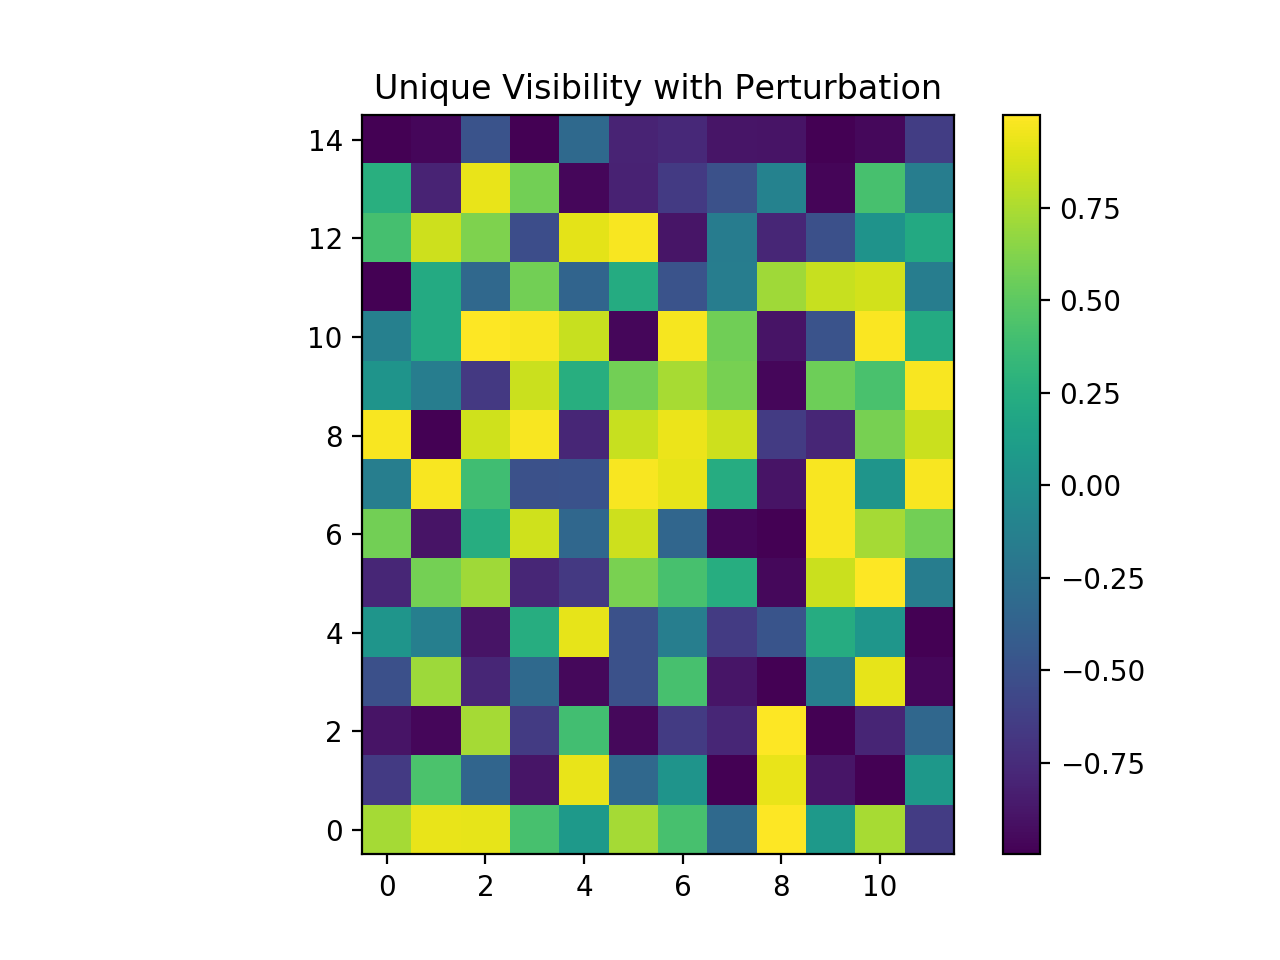

<IPython.core.display.Javascript object>


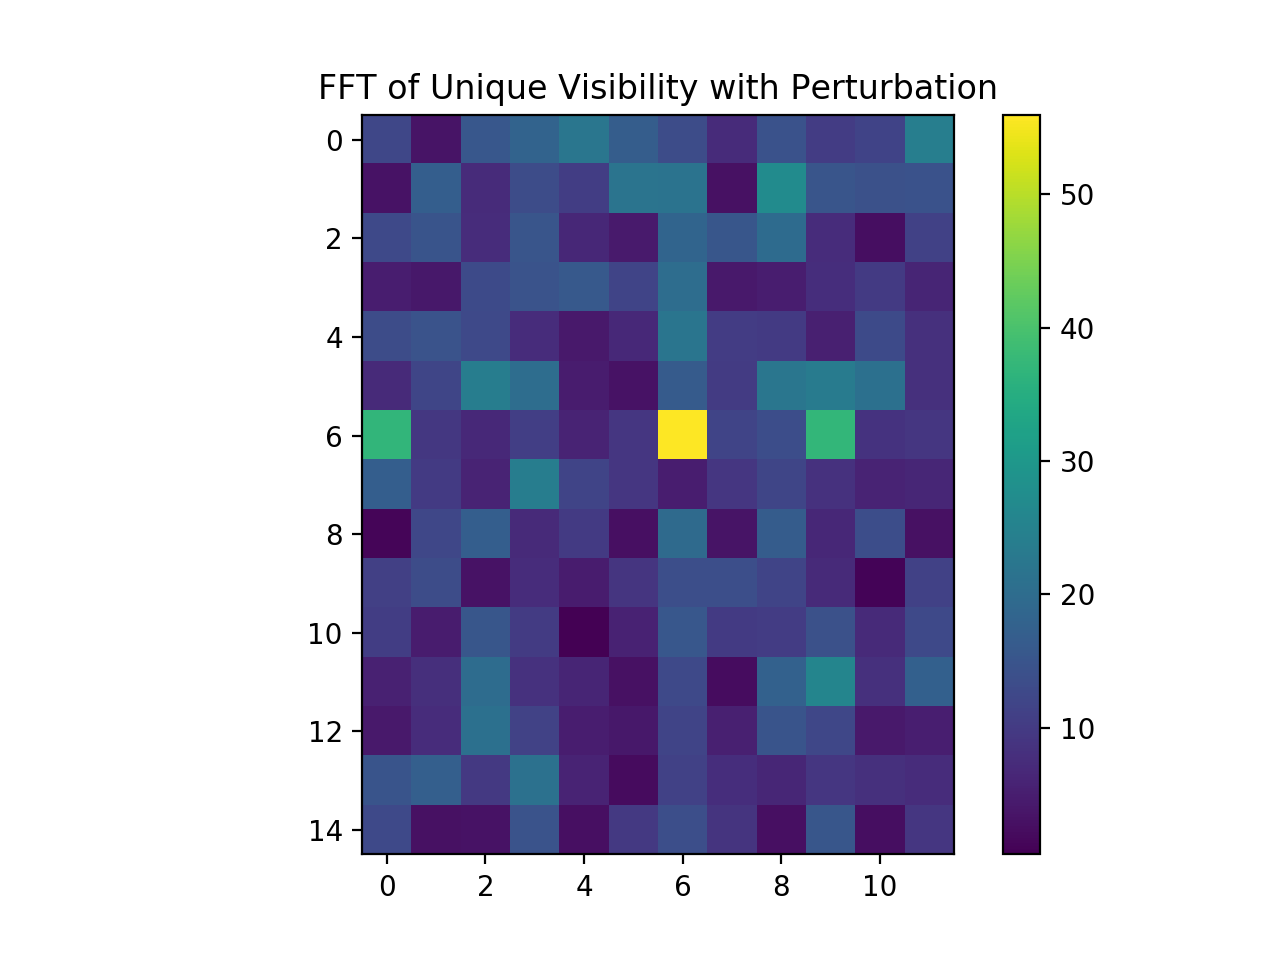

In [33]:
import hera_cal
from hera_cal.redcal import get_pos_reds

antposP = {}
n = 0
for j in range(10):
    for i in range(10):
        n += 1
        perturb = np.random.randn(2)*0.01
        antposP[n] = np.array([i,j]) + perturb
#print(antpos)
redsP = get_pos_reds(antposP, 0.1)
r = [1,2,5]
Vperturb = get_Vis_from_antpos(antposP, r)
Vperturb = Vperturb.reshape(15,12)

plt.figure()
plt.title("Unique Visibility with Perturbation")
plt.imshow(Vperturb.real,origin='lower')
plt.colorbar()

plt.figure()
plt.title("FFT of Unique Visibility with Perturbation")
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(Vperturb))))
plt.colorbar()
plt.show()
